In [1]:
import numpy as np
import torch.nn as nn 
from torchinfo import summary 
from torch.utils.data import DataLoader, Dataset 
import random 
import torch 
import matplotlib.pyplot as plt

### Loading Data

In [2]:
data = np.load('D:\Vanessa\Documents\eeg_data\processed_eeg_data.npz')
# data = np.load("D:\Vanessa\Documents\eeg_data\denoised_eeg_data.npz")
X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\Vanessa\AppData\Local\Temp\ipykernel_8232\3682215561.py:1: SyntaxWarning: invalid escape sequence '\V'
  data = np.load('D:\Vanessa\Documents\eeg_data\processed_eeg_data.npz')


In [3]:
# Change data structure to tensor
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

        # Calculate weights (3.6:1 downsampling ratio)
        self.weights = torch.where(self.y == 1,
                                   torch.tensor(3.6),   # seizure samples
                                   torch.tensor(1.0))   # non- seizure samples

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

### Models 

In [4]:
class CNNLSTM1(nn.Module):
# Input size is 8282*23*256 num samples x channels x time steps 
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNNLSTM1, self).__init__()
        self.conv1 = nn.Conv1d(23, conv_channel, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(conv_channel, conv_channel*2, kernel_size, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.lstm1 = nn.LSTM(conv_channel*2, conv_channel*4, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(conv_channel*4, 64, num_layers=2, batch_first=True)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)

        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x[:, -1, :]  # Take the last time step

        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

summary(CNNLSTM1(), input_size=(1, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM1                                 [1, 1]                    --
├─Conv1d: 1-1                            [1, 32, 256]              2,240
├─Conv1d: 1-2                            [1, 64, 256]              6,208
├─MaxPool1d: 1-3                         [1, 64, 128]              --
├─LSTM: 1-4                              [1, 128, 128]             231,424
├─Dropout: 1-5                           [1, 128, 128]             --
├─LSTM: 1-6                              [1, 128, 64]              82,944
├─Dropout: 1-7                           [1, 128, 64]              --
├─Linear: 1-8                            [1, 32]                   2,080
├─Linear: 1-9                            [1, 1]                    33
Total params: 324,929
Trainable params: 324,929
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 42.40
Input size (MB): 0.02
Forward/backward pass size (MB): 0.39
Params size (MB): 1.30
Estimated T

In [ ]:
class CNNLSTM2(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNNLSTM2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size, padding=1), #32
            nn.BatchNorm1d(conv_channel),
            nn.ReLU(),
            #nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(conv_channel, conv_channel*2, kernel_size, padding=1), #64
            nn.BatchNorm1d(conv_channel*2),
            nn.ReLU(), 
            #nn.MaxPool1d(2)
        )

        self.lstm = nn.LSTM(conv_channel*2, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(64*2, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Additional layer for output

    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x) 
        x = x.permute(0, 2, 1) 
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :]) 
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return self.fc3(x)
    
summary(CNNLSTM2(), (1, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM2                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 32, 128]              --
│    └─Conv1d: 2-1                       [1, 32, 256]              2,240
│    └─BatchNorm1d: 2-2                  [1, 32, 256]              64
│    └─ReLU: 2-3                         [1, 32, 256]              --
│    └─MaxPool1d: 2-4                    [1, 32, 128]              --
├─Sequential: 1-2                        [1, 64, 64]               --
│    └─Conv1d: 2-5                       [1, 64, 128]              6,208
│    └─BatchNorm1d: 2-6                  [1, 64, 128]              128
│    └─ReLU: 2-7                         [1, 64, 128]              --
│    └─MaxPool1d: 2-8                    [1, 64, 64]               --
├─LSTM: 1-3                              [1, 64, 128]              66,560
├─Dropout: 1-4                           [1, 128]                  --
├─Li

In [8]:
class ChronoNet(nn.Module):
    def __init__(self, output_layers=32, kernel_size=3, dropout_rate=0.5):
        super(ChronoNet, self).__init__()

        # Multi-kernel CNN block
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(23, 32, kernel_size=k, padding=k//2),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            ) for k in [3, 5, 7]
        ])

        # GRU block
        self.gru = nn.GRU(
            input_size=32 * len(self.convs),
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):  # x: (B, C=23, T=256)
        conv_outs = [conv(x) for conv in self.convs]  # List of (B, 32, T//2)
        x = torch.cat(conv_outs, dim=1)  # (B, 32*3, T//2)
        x = x.permute(0, 2, 1)  # (B, T//2, features)
        x, _ = self.gru(x)  # (B, T//2, hidden*2)
        x = x[:, -1, :]  # Take last time step
        return self.fc(x)
    
summary(ChronoNet(), (1, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ChronoNet                                [1, 1]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 128]              --
│    │    └─Conv1d: 3-1                  [1, 32, 256]              2,240
│    │    └─BatchNorm1d: 3-2             [1, 32, 256]              64
│    │    └─ReLU: 3-3                    [1, 32, 256]              --
│    │    └─MaxPool1d: 3-4               [1, 32, 128]              --
│    └─Sequential: 2-2                   [1, 32, 128]              --
│    │    └─Conv1d: 3-5                  [1, 32, 256]              3,712
│    │    └─BatchNorm1d: 3-6             [1, 32, 256]              64
│    │    └─ReLU: 3-7                    [1, 32, 256]              --
│    │    └─MaxPool1d: 3-8               [1, 32, 128]              --
│    └─Sequential: 2-3                   [1, 32, 128]              --
│    │   

### Model Training

In [17]:
def get_F1_score_accuracy(y_pred, y_true):
    if y_pred.max().item() > 1 or y_pred.min().item() < 0:
        y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()

    y_pred = (y_pred > 0.5).float()
    y_true = y_true.float()

    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    FN = ((y_pred == 0) & (y_true == 1)).sum().item()
    TN = ((y_pred == 0) & (y_true == 0)).sum().item()

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    F1 = 2 * (recall * precision) / (recall + precision) if (recall + precision) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return F1, accuracy


In [18]:
def metrics(model, data_loader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)

            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    F1, acc = get_F1_score_accuracy(all_preds, all_labels)

    return F1, acc

In [19]:
from torch.utils.data import Subset
train_dataset_small = Subset(EEGDataset(X_train, y_train), range(500))
val_dataset_small = Subset(EEGDataset(X_val, y_val), range(100))

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)

In [20]:

def train_model(model_class, train_dataset, val_dataset, output_layers=32, kernel_size=3, dropout_rate=0.3, learning_rate=0.005, batch_size=32, num_epoch=40):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model_class(
        output_layers,
        kernel_size,
        dropout_rate
    ).to(device)

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()

    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epoch):
        model.train()
        losses = 0.0
        for inputs, labels, batch_weights in train_loader:
            # Move date to device
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            batch_weights = batch_weights.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply weighting and bachpropagate
            loss = loss.view(-1)  
            weighted_loss = (batch_weights * loss).mean()   # Element-wise weighting
            weighted_loss.backward()
            
            # Update weights
            optimizer.step()
            losses += weighted_loss.item()
        train_loss.append(losses / len(train_loader))
        
        model.eval()
        losses = 0.0
        with torch.no_grad():
            for inputs, labels , _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                losses += loss.item()
        val_loss.append(losses / len(val_loader))

        train_f1, train_accuracy = metrics(model, train_loader)
        val_f1, val_accuracy = metrics(model, val_loader)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc[-1]:.4f}, Val F1: {val_f1:.4f}")


    print("========== Final Metrics ==========")
    print(f"Final Train Loss: {train_loss[-1]:.4f}")
    print(f"Final Val Loss:   {val_loss[-1]:.4f}")
    print(f"Final Train Acc:  {train_acc[-1]:.4f}")
    print(f"Final Val Acc:    {val_acc[-1]:.4f}")  # If you're computing it


    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50, Train Loss: 1.0617, Val Loss: 0.6921, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 2/50, Train Loss: 0.9841, Val Loss: 0.7950, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 3/50, Train Loss: 0.9185, Val Loss: 0.7615, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 4/50, Train Loss: 0.8578, Val Loss: 0.7425, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 5/50, Train Loss: 0.8119, Val Loss: 0.7482, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 6/50, Train Loss: 0.7888, Val Loss: 0.7261, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 7/50, Train Loss: 0.7249, Val Loss: 0.7875, Train Acc: 0.7500, Train F1: 0.0000, Val Acc: 0.5400, Val F1: 0.0000
Epoch 8/50, Train Loss: 0.6459, Val Loss: 0.9140, Train Acc: 0.8540, Train F1: 0.6368, Val Acc: 0.6100, Val F1: 0.3810
Epoch 9/50, Train Loss: 0.5810, Val Loss: 0.7684

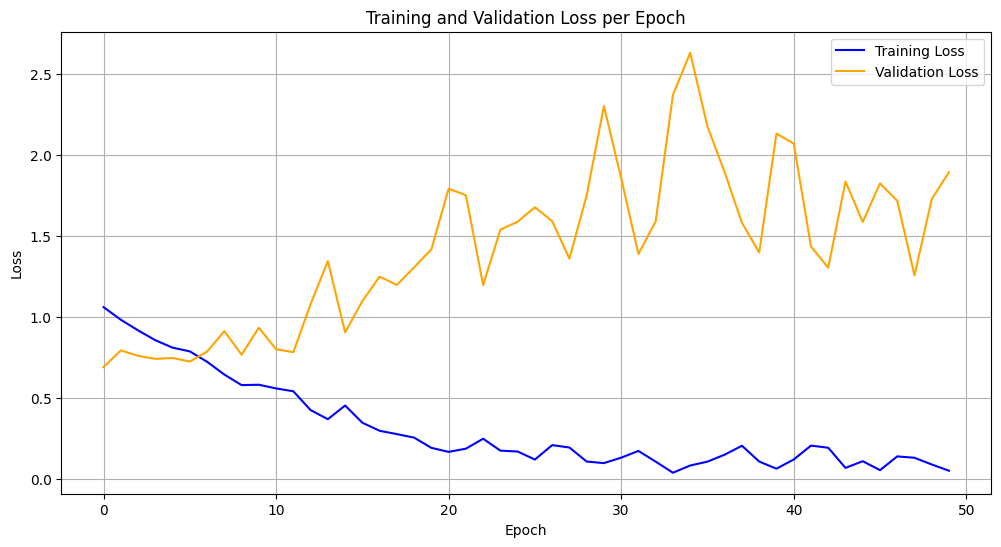

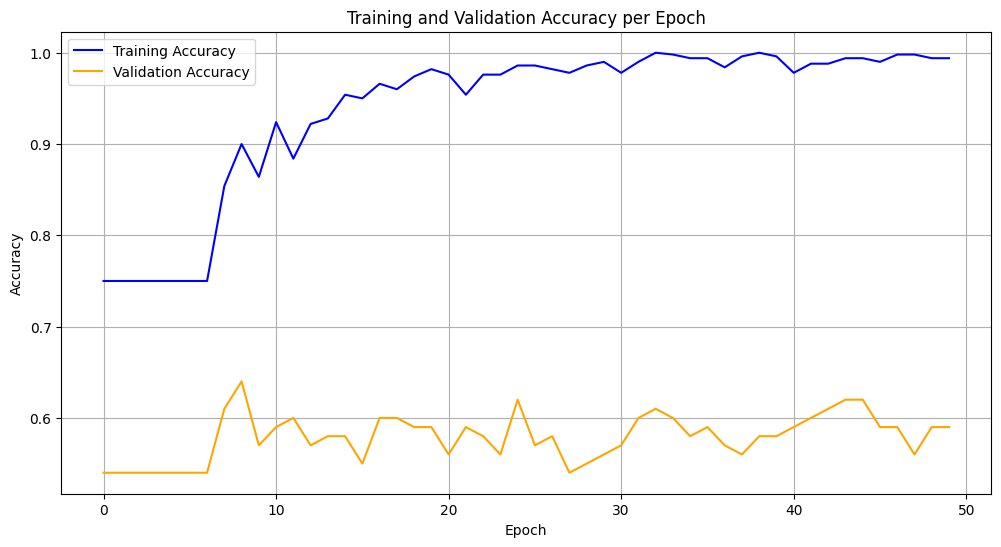

In [22]:
train_model(CNNLSTM2, train_dataset_small, val_dataset_small, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.005, batch_size=32, num_epoch=50)

Epoch 1/50, Train Loss: 0.8389, Val Loss: 0.8812, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 2/50, Train Loss: 0.8217, Val Loss: 0.7955, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 3/50, Train Loss: 0.8033, Val Loss: 0.8785, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 4/50, Train Loss: 0.7876, Val Loss: 0.8370, Train Acc: 0.7859, Train F1: 0.0285, Val Acc: 0.5030, Val F1: 0.0121
Epoch 5/50, Train Loss: 0.7851, Val Loss: 0.7883, Train Acc: 0.7864, Train F1: 0.0296, Val Acc: 0.5061, Val F1: 0.0241
Epoch 6/50, Train Loss: 0.7658, Val Loss: 0.8403, Train Acc: 0.7917, Train F1: 0.0926, Val Acc: 0.5198, Val F1: 0.0762
Epoch 7/50, Train Loss: 0.7579, Val Loss: 0.7475, Train Acc: 0.8021, Train F1: 0.2871, Val Acc: 0.5488, Val F1: 0.2128
Epoch 8/50, Train Loss: 0.7767, Val Loss: 0.8208, Train Acc: 0.7936, Train F1: 0.1485, Val Acc: 0.5244, Val F1: 0.1034
Epoch 9/50, Train Loss: 0.7589, Val Loss: 0.8405

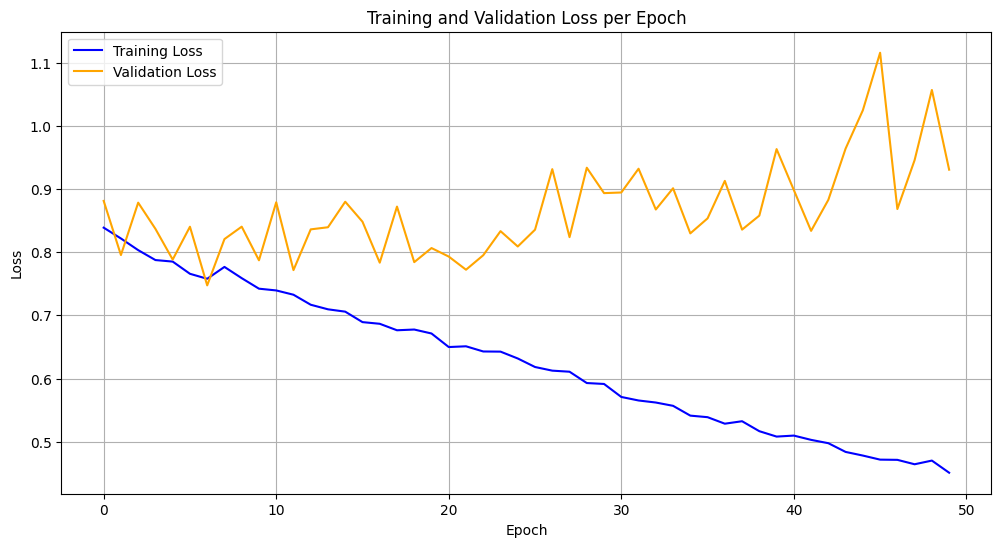

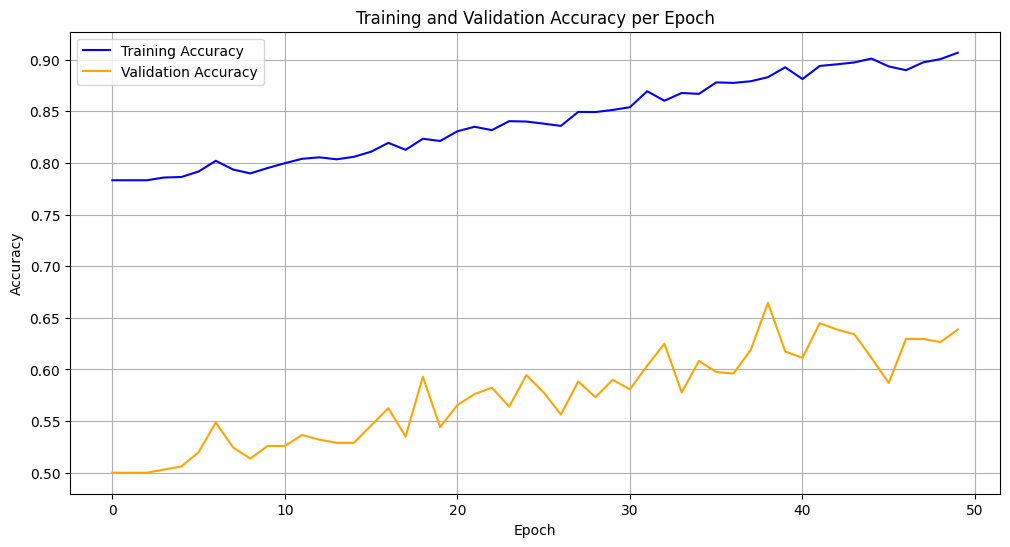

In [21]:
train_model(CNNLSTM2, train_dataset, val_dataset, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.005, batch_size=32, num_epoch=50)

# MACHINE NOT LEARNINGGGGG :(

In [24]:
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
print(num_pos, num_neg)

1795 6487


Epoch 1/50, Train Loss: 0.8581, Val Loss: 0.9057, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 2/50, Train Loss: 0.8465, Val Loss: 0.8583, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 3/50, Train Loss: 0.8387, Val Loss: 0.9216, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 4/50, Train Loss: 0.8389, Val Loss: 0.8571, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 5/50, Train Loss: 0.8364, Val Loss: 0.8672, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 6/50, Train Loss: 0.8375, Val Loss: 0.8692, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 7/50, Train Loss: 0.8340, Val Loss: 0.8588, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 8/50, Train Loss: 0.8334, Val Loss: 0.8598, Train Acc: 0.7833, Train F1: 0.0000, Val Acc: 0.5000, Val F1: 0.0000
Epoch 9/50, Train Loss: 0.8335, Val Loss: 0.8828

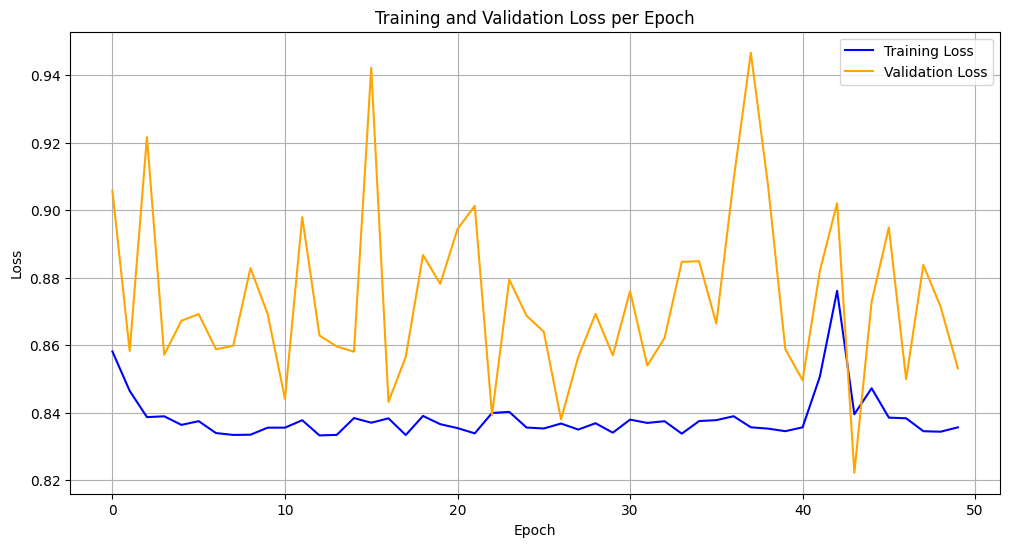

In [40]:
train_model(CNNLSTM1, train_dataset, val_dataset, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.05, batch_size=32, num_epoch=50)

### Hyperparameter Tuning

In [ ]:
search = {
    'output_layers': [16, 32, 64],
    'kernel_size': [3, 5, 7],
    'dropout_rate': [0.2, 0.5, 0.7],
    'learning_rate': [0.01, 0.005, 0.001, 0.0001],
    'batch_size': [16, 32, 64, 128]
}